# <center>Otimização de tabela do Campeonato Brasileiro de Futebol usando Algoritmos Genéticos</center>

## 1. Introdução

O Campeonato Brasileiro de Futebol é o principal torneio do esporte mais popular do país. Com 20 times, tem representantes de quase todas as regiões do Brasil (região Norte já esteve presente em edições passadas). Como o Brasil é um país de tamanho continental, o torneio envolve viagens longas, principalmente para os times do Nordeste.<br> 

A partir do conjunto de premissas apresentadas adiante, vamos utilizar Algoritmos Genéticos para propor uma tabela que minimize o impacto dessas longas viagens, embora seja claro que haverá times que estão geograficamente mais distantes e não há como evitar diferenças. Propomos três métricas para essa otimização, todas utilizando as  distâncias viajadas por cada time.<br>

Esse é um tipo de problema conhecido como TTP (*Traveling Tournament Problem*), Problema de Torneio Itinerante. Existe um conjunto gigante de possíveis ordenamentos e é bastante complicado obter o resultado ótimo, principalmente com um número grande de participantes. 

## 2. Dados disponíveis

Temos duas entradas importantes para poder realizar esse estudo.
1. A lista de times participantes do campeonato;
2. A tabela do campeonato de 2020.

**Vamos importar as bibliotecas necessárias para apresentar os dados.**

In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

### 2.1. Lista de participantes

Precisamos da lista com o nome dos 20 participantes do campeonato, junto com a sua cidade de origem. Como estamos interessados na distância viajada por cada equipe, vamos pegar as coordenadas (latitude e longitude) do ponto central de cada cidade para calcular o percurso entre as partidas.

In [280]:
lista_times_20=pd.read_csv('times.csv')
lista_times_20.head()

,Time,Cidade
0,Atlético Goianiense,Goiânia
1,Atlético Mineiro,Belo Horizonte
2,Athletico Paranaense,Curitiba
3,Bahia,Salvador
4,Botafogo,Rio de Janeiro


Montaremos posteriormente uma tabela 20x20 com a distância entre as cidades de cada time.

### 2.2. Tabela de 2020

Pegamos como ponto de partida a programação do campeonato de 2020, onde temos a ordem das partidas para cada um dos 20 times. O torneio é realizado em duas fases, onde a segunda parte repete os jogos da primeira, com mando de campo invertido. Com isso, só precisamos nos preocupar com a metade dos jogos.

Para o nosso problema, organizamos a montagem das primeiras 19 rodadas em duas tabelas, uma com a sequência de times enfrentados e outra com a sequência de mandos de campo (*casa/fora*).

#### 2.2.1 Sequência de jogos

In [281]:
enfrentamentos_20=pd.read_csv('enfrentamentos.csv')
enfrentamentos_20.head()

,Time,Rodada 1,Rodada 2,Rodada 3,Rodada 4,Rodada 5,Rodada 6,Rodada 7,Rodada 8,Rodada 9,Rodada 10,Rodada 11,Rodada 12,Rodada 13,Rodada 14,Rodada 15,Rodada 16,Rodada 17,Rodada 18,Rodada 19
0,Athlético Paranaense,Fortaleza,Goiás,Santos,Palmeiras,Fluminense,Atlético Mineiro,Red Bull Bragantino,Vasco da Gama,Botafogo,Coritiba,São Paulo,Bahia,Flamengo,Ceará,Internacional,Corinthians,Atlético Goianiense,Grêmio,Sport
1,Atlético Goianiense,Corinthians,Flamengo,Sport,Internacional,Goiás,Ceará,Fluminense,Grêmio,Vasco da Gama,Bahia,Atlético Mineiro,Botafogo,Fortaleza,São Paulo,Red Bull Bragantino,Santos,Athlético Paranaense,Palmeiras,Coritiba
2,Atlético Mineiro,Flamengo,Corinthians,Ceará,Botafogo,Internacional,Athlético Paranaense,São Paulo,Coritiba,Santos,Red Bull Bragantino,Atlético Goianiense,Grêmio,Vasco da Gama,Fortaleza,Goiás,Fluminense,Bahia,Sport,Palmeiras
3,Bahia,Botafogo,Coritiba,Red Bull Bragantino,São Paulo,Ceará,Palmeiras,Flamengo,Internacional,Grêmio,Atlético Goianiense,Corinthians,Athlético Paranaense,Sport,Vasco da Gama,Fluminense,Goiás,Atlético Mineiro,Fortaleza,Santos
4,Botafogo,Bahia,Red Bull Bragantino,Fortaleza,Atlético Mineiro,Flamengo,Internacional,Coritiba,Corinthians,Athlético Paranaense,Vasco da Gama,Santos,Atlético Goianiense,Fluminense,Palmeiras,Sport,Grêmio,Goiás,São Paulo,Ceará


#### 2.2.2 Mando de campo

In [282]:
mando_20=pd.read_csv('mando.csv')
mando_20.head()

,Time,Rodada 1,Rodada 2,Rodada 3,Rodada 4,Rodada 5,Rodada 6,Rodada 7,Rodada 8,Rodada 9,Rodada 10,Rodada 11,Rodada 12,Rodada 13,Rodada 14,Rodada 15,Rodada 16,Rodada 17,Rodada 18,Rodada 19
0,Athlético Paranaense,f,c,f,c,c,f,c,f,c,c,f,c,f,c,f,c,f,c,f
1,Atlético Goianiense,f,c,c,f,f,c,f,c,f,f,c,c,f,f,c,f,c,c,f
2,Atlético Mineiro,f,c,c,f,f,c,c,f,f,c,f,c,c,f,c,c,f,c,f
3,Bahia,f,c,c,f,f,c,c,f,c,c,f,f,c,c,f,f,c,c,f
4,Botafogo,c,f,f,c,f,c,c,f,f,c,c,f,c,c,f,f,c,f,c


## 3. Metodologia

Esse problema é complexo, pois envolve muitas combinações possíveis. Para o Campeonato Brasileiro, o mais provável é que a tabela seja montada de maneira artesanal, respeitando apenas uma premissa:
1. Nenhum time pode jogar mais do que duas partidas seguidas em casa ou fora.


Para o nosso exercício, vamos trabalhar com uma versão *express* do Campeonato Brasileiro. O campeonato continua com as suas 38 rodadas, mas temos mais uma premissa em nosso modelo: são duas partidas por semana.

2. O time não retorna para sua cidade após cada partida, indo diretamente para a sede da próxima partida.

Isso só é relevante para a avaliação dos resultados do algoritmo genético, não influenciando na tabela de jogos.

Temos 4 tabelas em nosso conjunto de dados:
1. lista de times
2. lista de confrontos
3. lista de mandos de campo
4. distância entre sedes

A última tabela é apenas utilizada na função de avaliação. Vamos mexer nas três outras tabelas para podermos aplicar nosso algoritmo genético.

Primeiramente, vamos generalizar as tabelas, substituindo os nomes dos times por uma posição da equipe. Por exemplo, Athlético Paranaense será subtituido por Time01, Atlético Goianiense como Time02, etc. Dessa forma, temos três novas tabelas genéricas.

In [283]:
generico=['Time01','Time02','Time03','Time04','Time05','Time06','Time07','Time08','Time09','Time10','Time11','Time12','Time13','Time14','Time15','Time16','Time17','Time18','Time19','Time20']

In [284]:
lista=lista_times_20['Time'].tolist()
lista_times = lista_times_20.replace(lista,generico)
lista_times.drop(columns=['Cidade'],inplace=True)
lista_times = lista_times.set_index('Time')
lista_times.head()

""
Time
Time01
Time02
Time03
Time04
Time05


In [285]:
lista = enfrentamentos_20['Time'].tolist()
enfrentamentos = enfrentamentos_20.replace(lista,generico)
enfrentamentos = enfrentamentos.set_index('Time')
enfrentamentos.head()

,Rodada 1,Rodada 2,Rodada 3,Rodada 4,Rodada 5,Rodada 6,Rodada 7,Rodada 8,Rodada 9,Rodada 10,Rodada 11,Rodada 12,Rodada 13,Rodada 14,Rodada 15,Rodada 16,Rodada 17,Rodada 18,Rodada 19
Time,,,,,,,,,,,,,,,,,,,
Time01,Time11,Time12,Time17,Time15,Time10,Time03,Time16,Time20,Time05,Time08,Time18,Time04,Time09,Time06,Time14,Time07,Time02,Time13,Time19
Time02,Time07,Time09,Time19,Time14,Time12,Time06,Time10,Time13,Time20,Time04,Time03,Time05,Time11,Time18,Time16,Time17,Time01,Time15,Time08
Time03,Time09,Time07,Time06,Time05,Time14,Time01,Time18,Time08,Time17,Time16,Time02,Time13,Time20,Time11,Time12,Time10,Time04,Time19,Time15
Time04,Time05,Time08,Time16,Time18,Time06,Time15,Time09,Time14,Time13,Time02,Time07,Time01,Time19,Time20,Time10,Time12,Time03,Time11,Time17
Time05,Time04,Time16,Time11,Time03,Time09,Time14,Time08,Time07,Time01,Time20,Time17,Time02,Time10,Time15,Time19,Time13,Time12,Time18,Time06


In [286]:
lista =mando_20['Time'].tolist()
mando = mando_20.replace(lista,generico)
mando = mando.replace(['c','f'],[0,1])
mando = mando.set_index('Time')
mando.head()

,Rodada 1,Rodada 2,Rodada 3,Rodada 4,Rodada 5,Rodada 6,Rodada 7,Rodada 8,Rodada 9,Rodada 10,Rodada 11,Rodada 12,Rodada 13,Rodada 14,Rodada 15,Rodada 16,Rodada 17,Rodada 18,Rodada 19
Time,,,,,,,,,,,,,,,,,,,
Time01,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1
Time02,1,0,0,1,1,0,1,0,1,1,0,0,1,1,0,1,0,0,1
Time03,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,1
Time04,1,0,0,1,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1
Time05,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,1,0,1,0


De novo, esse problema é muito complexo. Precisaríamos trabalhar com as três tabelas ao mesmo tempo para chegar na solução ótima. Como não temos a menor ideia de como fazer isso, vamos atacar o problema em três frentes.

### 3.1. Lista de times

Vamos tentar otimizar a ordem dos times, mantendo as duas outras tabelas fixas. Ou seja, a questão é definir qual equipe é o Time01, qual é o Time02, até o Time20. 

In [287]:
print('Existem',math.factorial(20),'possibilidades para esse arranjo de times.')

Existem 2432902008176640000 possibilidades para esse arranjo de times.


Obviamente esse é um problema que teria um alto custo computacional caso fosse necessário varrer todas as possibilidades.

Em nosso algoritmo genético, o nosso gene é um vetor com números de 0 a 19, correlacionando a lista de equipes participantes com as etiquetas Time01, Time02,..., Time20. A mutação proposta em cada geração é a mudança de posição entre duas equipes.

### 3.2. Mandos de campo

Vamos tentar otimizar os mandos de campo, mantendo as duas outras tabelas fixas. Ou seja, a questão é definir a sequência de jogos em casa ou fora para cada equipe, mas devemos respeitar a premissa de não ter mais de duas partidas em casa ou fora em sequência.

Em nosso algoritmo genético, o nosso gene é a matriz 20x19, onde cada linha é um time e cada coluna é uma rodada.  A mutação proposta em cada geração é a escolha aleatória de uma partida na tabela de enfrentamentos e a inversão do mando de campo na outra tabela. Ela deve respeitar a premissa, ou seja, uma mutação só será aceita se não criar um caso onde haja 3 partidas seguidas em casa ou fora para os dois times envolvidos.

### 3.3. Ordem de enfrentamentos

Vamos tentar otimizar a ordem das rodadas, mantendo as duas outras tabelas fixas. Ou seja, a questão é definir a sequência de times que cada um vai enfrentar. De novo, precisamos respeitar a premissa de não ter mais de duas partidas em casa ou fora em sequência.

Em nosso algoritmo genético, o nosso gene é um vetor com números de 0 a 18. A mutação proposta em cada geração é a mudança de posição entre duas rodadas. Ela deve respeitar a premissa, ou seja, uma mutação só será aceita se não criar um caso onde haja 3 partidas seguidas em casa ou fora para os dois times envolvidos.

## 4. Atualização para 2021

Vamos carregar a lista de participantes para o Campeonato de 2021, com as cidades de cada equipe. 

In [288]:
lista_times_21=pd.read_csv('times_21.csv')
lista_times_21.head()

,Time,Cidade
0,América,Belo Horizonte
1,Athlético Paranaense,Curitiba
2,Atlético Goianiense,Goiânia
3,Atlético Mineiro,Belo Horizonte
4,Bahia,Salvador


Vamos usar uma biblioteca que retorna as coordenadas (Latitude e Longitude) de cada cidade e vamos criar uma tabela com a distância entre as cidades. Cada linha é um dos times, assim como as colunas.

Importando as bibliotecas necessárias.

In [289]:
!pip3 install geopy
from geopy.geocoders import Nominatim
import time
app = Nominatim(user_agent="gabrasileirao")

Definindo a função que busca as coordenadas.

In [290]:
def get_location_by_address(address):
    """This function returns a location as raw from an address
    will repeat until success"""
    time.sleep(1)
    try:
        return app.geocode(address).raw
    except:
        return get_location_by_address(address)

Buscando as coordenadas para cada cidade na lista.

In [275]:
lista_times_21['Latitude']=0.
lista_times_21['Longitude']=0.
for ii in range(lista_times_21.shape[0]):
    print(ii)
    address = [lista_times_21.iloc[ii,1],'Brazil']
    location = get_location_by_address(address)
    lista_times_21.iloc[ii,-2] = location["lat"]
    lista_times_21.iloc[ii,-1] = location["lon"]
lista_times_21.head()

0


AttributeError: 'str' object has no attribute 'sleep'

In [40]:
lista_times_21['Latitude']=lista_times_21['Latitude'].astype(float)
lista_times_21['Longitude']=lista_times_21['Longitude'].astype(float)

Vamos conferir no mapa se está tudo correto.

In [41]:
!pip install folium
import folium # map rendering library

In [42]:
#mapa centrado em Brasília
map_brasil = folium.Map(location=[-10.3333333, -53.2], zoom_start=4)

# add markers to map
for lat, lng, time in zip(lista_times_21['Latitude'], lista_times_21['Longitude'], lista_times_21['Time']):
    label = '{}'.format(time)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brasil)  
    
map_brasil

Temos nossos 20 times espalhados em 14 cidades, em 11 estados. Agora precisamos construir a tabela com as distâncias. De novo, vamos definir uma função que faz esse cálculo.

Vamos criar a tabela e depois populá-la com as distâncias.

In [45]:
distancias=pd.DataFrame(columns=['Time']+lista_times_21['Time'].tolist())
distancias['Time']=lista_times_21['Time'].tolist()
distancias.head()

,Time,América,Athlético Paranaense,Atlético Goianiense,Atlético Mineiro,Bahia,Bragantino,Ceará,Chapecoense,Corinthians,...,Flamengo,Fluminense,Fortaleza,Grêmio,Internacional,Juventude,Palmeiras,Santos,São Paulo,Sport
0,América,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Athlético Paranaense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Atlético Goianiense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Atlético Mineiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bahia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Importando a biblioteca que calcula a distância a partir das coordenadas.

In [269]:
!pip install haversine
import haversine as hs


In [47]:
for ii in range(len(lista_times_21)):
    for jj in range(len(lista_times_21)):
        loc1=(lista_times_21.iloc[ii,-2],lista_times_21.iloc[ii,-1])
        loc2=(lista_times_21.iloc[jj,-2],lista_times_21.iloc[jj,-1])
        distancias.iloc[ii,jj+1]=hs.haversine(loc1,loc2)

distancias.head()

,Time,América,Athlético Paranaense,Atlético Goianiense,Atlético Mineiro,Bahia,Bragantino,Ceará,Chapecoense,Corinthians,...,Flamengo,Fluminense,Fortaleza,Grêmio,Internacional,Juventude,Palmeiras,Santos,São Paulo,Sport
0,América,0,820.485,666.215,0,966.725,430.9,1894.08,1189.77,489.691,...,340.896,340.896,1894.08,1341.83,1341.83,1261.11,489.691,512.134,489.691,1640.7
1,Athlético Paranaense,820.485,0,972.816,820.485,1786.64,390.537,2672.15,381.377,338.956,...,675.611,675.611,2672.15,546.903,546.903,456.486,338.956,338.708,338.956,2460.42
2,Atlético Goianiense,666.215,972.816,0,666.215,1228.42,752.725,1856.43,1208.38,811.308,...,937.644,937.644,1856.43,1498.19,1498.19,1402.42,811.308,864.739,811.308,1830
3,Atlético Mineiro,0,820.485,666.215,0,966.725,430.9,1894.08,1189.77,489.691,...,340.896,340.896,1894.08,1341.83,1341.83,1261.11,489.691,512.134,489.691,1640.7
4,Bahia,966.725,1786.64,1228.42,966.725,0,1397.62,1028.76,2150.66,1455.69,...,1211.69,1211.69,1028.76,2305.24,2305.24,2226.57,1455.69,1474.19,1455.69,673.975


In [48]:
distancias=distancias.set_index('Time')
distancias.head()

,América,Athlético Paranaense,Atlético Goianiense,Atlético Mineiro,Bahia,Bragantino,Ceará,Chapecoense,Corinthians,Cuiabá,Flamengo,Fluminense,Fortaleza,Grêmio,Internacional,Juventude,Palmeiras,Santos,São Paulo,Sport
Time,,,,,,,,,,,,,,,,,,,,
América,0,820.485,666.215,0,966.725,430.9,1894.08,1189.77,489.691,1373.35,340.896,340.896,1894.08,1341.83,1341.83,1261.11,489.691,512.134,489.691,1640.7
Athlético Paranaense,820.485,0,972.816,820.485,1786.64,390.537,2672.15,381.377,338.956,1303.37,675.611,675.611,2672.15,546.903,546.903,456.486,338.956,338.708,338.956,2460.42
Atlético Goianiense,666.215,972.816,0,666.215,1228.42,752.725,1856.43,1208.38,811.308,741.012,937.644,937.644,1856.43,1498.19,1498.19,1402.42,811.308,864.739,811.308,1830
Atlético Mineiro,0,820.485,666.215,0,966.725,430.9,1894.08,1189.77,489.691,1373.35,340.896,340.896,1894.08,1341.83,1341.83,1261.11,489.691,512.134,489.691,1640.7
Bahia,966.725,1786.64,1228.42,966.725,0,1397.62,1028.76,2150.66,1455.69,1919.91,1211.69,1211.69,1028.76,2305.24,2305.24,2226.57,1455.69,1474.19,1455.69,673.975


In [83]:
print('Por exemplo, a distância entre as sedes de Bahia e Grêmio é:',distancias.loc['Bahia','Grêmio'],'quilômetros.')

Por exemplo, a distância entre as sedes de Bahia e Grêmio é: 2305.244411273193 quilômetros.


## 5. Métrica de avaliação

O parâmetro que usaremos para avaliação é a distância percorrida por cada equipe. Por exemplo, para o Time01, é a distância entre a sua cidade e o local da sua primeira partida, mais a distância entre o local da primeira partida e o local da segunda, e assim por diante. <br>
Lembrando, nossas duas premissas são:
1. Nenhum time pode jogar mais do que duas partidas seguidas em casa ou fora.
2. O time não retorna para sua cidade após cada partida, indo diretamente para a sede da próxima partida.

Independente da métrica que usarmos para avaliar os genes, o vetor com a distância percorrida por cada equipe será o dado fundamental.

Temos 3 opções para uma métrica:
1. minimização da soma total de distâncias;
2. minimização da diferença entre maior e menor distância percorrida;
3. minimização do desvio padrão da distribuição de distâncias.

Para o nosso exercício, queremos minimizar o impacto de longas viagens no desempenho dos times. Com isso em mente, vamos nos concentrar na opção 3, minimizar o desvio padrão da distribuição das distâncias. Podemos ter *outliers* com distâncias muito grandes ou muito pequenas, mas garantimos que a maior parte das equipes fique próxima da média.

Abaixo, vamos montar o percurso de cada time, somar a distância viajada e depois calcular o desvio padrão da distribuição gerada. Uma vez entendido o processo, criaremos uma função que será chamada para avaliar cada solução proposta pelo nosso algoritmo.

Com base na tabela de mandos de campo e de enfrentamentos, vamos construir o percurso de cada time, começando e terminando em sua casa. 

In [308]:
rodadas=['Rodada 1', 'Rodada 2', 'Rodada 3', 'Rodada 4', 'Rodada 5', 'Rodada 6', 'Rodada 7', 'Rodada 8', 
         'Rodada 9', 'Rodada 10', 'Rodada 11', 'Rodada 12', 'Rodada 13', 'Rodada 14', 'Rodada 15', 'Rodada 16', 
         'Rodada 17', 'Rodada 18', 'Rodada 19']

percursos=[]
for jj in range(len(generico)):
    percurso_time=[generico[jj]]+2*enfrentamentos.loc[generico[jj],:].tolist()+[generico[jj]]
    for ii in range(len(rodadas)):
        if mando.loc[generico[jj],rodadas[ii]]==0:
            percurso_time[ii+1]=generico[jj]
        else:
            percurso_time[ii+20]=generico[jj]

    percursos.append(percurso_time)
    
percursos=pd.DataFrame(percursos)
percursos

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,Time01,Time11,Time01,Time17,Time01,Time01,Time03,Time01,Time20,Time01,...,Time01,Time04,Time01,Time06,Time01,Time07,Time01,Time13,Time01,Time01
1,Time02,Time07,Time02,Time02,Time14,Time12,Time02,Time10,Time02,Time20,...,Time03,Time05,Time02,Time02,Time16,Time02,Time01,Time15,Time02,Time02
2,Time03,Time09,Time03,Time03,Time05,Time14,Time03,Time03,Time08,Time17,...,Time03,Time13,Time20,Time03,Time12,Time10,Time03,Time19,Time03,Time03
3,Time04,Time05,Time04,Time04,Time18,Time06,Time04,Time04,Time14,Time04,...,Time04,Time04,Time19,Time20,Time04,Time04,Time03,Time11,Time04,Time04
4,Time05,Time05,Time16,Time11,Time05,Time09,Time05,Time05,Time07,Time01,...,Time17,Time05,Time10,Time15,Time05,Time05,Time12,Time05,Time06,Time05
5,Time06,Time19,Time06,Time03,Time06,Time06,Time02,Time06,Time06,Time14,...,Time06,Time12,Time06,Time06,Time07,Time18,Time06,Time08,Time06,Time06
6,Time07,Time07,Time03,Time13,Time07,Time07,Time18,Time12,Time07,Time07,...,Time04,Time07,Time07,Time17,Time07,Time07,Time09,Time07,Time14,Time07
7,Time08,Time08,Time04,Time08,Time08,Time16,Time08,Time05,Time08,Time12,...,Time20,Time08,Time18,Time08,Time11,Time08,Time17,Time08,Time02,Time08
8,Time09,Time09,Time02,Time08,Time09,Time09,Time17,Time04,Time09,Time09,...,Time12,Time09,Time01,Time19,Time09,Time16,Time09,Time09,Time18,Time09
9,Time10,Time13,Time10,Time10,Time16,Time01,Time10,Time10,Time18,Time09,...,Time10,Time08,Time10,Time10,Time04,Time10,Time06,Time17,Time10,Time10


Para podermos testar a métrica de avaliação, vamos fazer um teste com os times em ordem alfabética.

In [239]:
lista_times['Equipe']=lista_times_21['Time'].tolist()
lista_times

,Equipe
Time,
Time01,América
Time02,Athlético Paranaense
Time03,Atlético Goianiense
Time04,Atlético Mineiro
Time05,Bahia
Time06,Bragantino
Time07,Ceará
Time08,Chapecoense
Time09,Corinthians


In [240]:
percorrido=[]
for ii in range(percursos.shape[0]):
    viagens=0
    for jj in range(percursos.shape[1]-1):
        viagens += distancias.loc[lista_times.loc[percursos.iloc[ii,jj],'Equipe'],
                                  lista_times.loc[percursos.iloc[ii,jj+1],'Equipe']]
    
    percorrido.append(viagens)

percorrido

[33927.29234496006,
 32426.72047417231,
 36496.76628806729,
 30730.49655365603,
 47255.36940387756,
 30670.87047040624,
 61438.53820635262,
 38094.91917244623,
 28040.881925323665,
 45986.311788132385,
 33528.92657628771,
 31681.023815858836,
 59378.06414520614,
 43220.460073022296,
 46907.126544911815,
 41491.07801763534,
 30336.391699852356,
 27631.877140120123,
 29895.210878326485,
 57428.050655022]

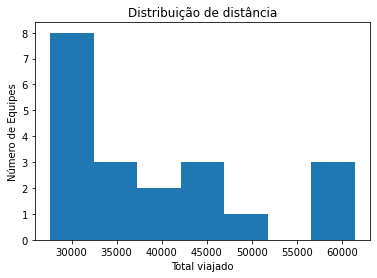

In [242]:
plt.hist(percorrido, bins = 3)
plt.xlabel('Total viajado')
plt.ylabel('Número de Equipes')
plt.title('Distribuição de distância')
plt.show()

Tendo a distribuição de distâncias percorridas, podemos calcular o desvio padrão, que será nossa métrica que tentaremos minimizar.

In [232]:
desvio_padrao = np.std(percorrido)
print('O desvio padrão para esse arranjo de times, mandos e enfrentamentos é:',desvio_padrao)

O desvio padrão para esse arranjo de times, mandos e enfrentamentos é: 10402.565550423853


Agora que já sabemos o passo-a-passo, vamos definir a função que nos retorna a métrica que desejamos minimizar.

In [95]:
def avaliacao(ordem_times,ordem_mandos,ordem_rodadas):
    percursos=[]
    rodadas=ordem_rodadas.columns
    for jj in range(len(generico)):
        percurso_time=[generico[jj]]+2*ordem_rodadas.loc[generico[jj],:].tolist()+[generico[jj]]
        for ii in range(len(rodadas)):
            if mando.loc[generico[jj],rodadas[ii]]==0:
                percurso_time[ii+1]=generico[jj]
            else:
                percurso_time[ii+ordem_times.shape[0]]=generico[jj]

        percursos.append(percurso_time)

    percursos=pd.DataFrame(percursos)
    percorrido=[]
    for ii in range(percursos.shape[0]):
        viagens=0
        for jj in range(percursos.shape[1]-1):
            viagens += distancias.loc[ordem_times.loc[percursos.iloc[ii,jj],'Equipe'],
                                      ordem_times.loc[percursos.iloc[ii,jj+1],'Equipe']]

        percorrido.append(viagens)
    
    desvio_padrao = np.std(percorrido)
    return desvio_padrao



## 6. Otimizando a lista de times

Vamos tentar otimizar a ordem dos times, mantendo as duas outras tabelas fixas. Ou seja, a questão é definir qual equipe é o Time01, qual é o Time02, até o Time20. 

In [112]:
enfrentamentos_solucao = enfrentamentos.copy()
mando_solucao = mando.copy()

Nosso gene é vetor com o ordenamento das equipes, a partir da lista em ordem alfabética. 

In [101]:
print('Ou seja, o vetor (0,1,2,3,4,5,6,7,8,9,10,11,12,13,141,15,16,17,18,19) é:', lista_times_21['Time'].tolist())

Ou seja, o vetor (0,1,2,3,4,5,6,7,8,9,10,11,12,13,141,15,16,17,18,19) é: ['América', 'Athlético Paranaense', 'Atlético Goianiense', 'Atlético Mineiro', 'Bahia', 'Bragantino', 'Ceará', 'Chapecoense', 'Corinthians', 'Cuiabá', 'Flamengo', 'Fluminense', 'Fortaleza', 'Grêmio', 'Internacional', 'Juventude', 'Palmeiras', 'Santos', 'São Paulo', 'Sport']


Ao final do algoritmo, vamos exibir o gráfico com a evolução do valor da melhor avaliação em cada geração. Esperamos que ao final o sistema atinja um valor otimizado.<br>
Temos quatro parâmetros para definir:
1. o número de genes que vamos avaliar em cada geração: 6;
2. o número de genes que vamos manter de uma geração para outra: 2;
3. o número de gerações: 500;
4. os genes originais.

Os seis genes originais serão escolhidos aleatoriamente abaixo.

In [171]:
import random
gene_pool=[]
for ii in range(6):
    gene = random.sample(range(0, 20),k=20)
    gene_pool.append(gene)
        
gene_pool=pd.DataFrame(gene_pool)
gene_pool

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,19,5,14,0,3,16,12,4,7,11,6,1,13,15,18,17,9,2,10,8
1,7,8,14,4,16,18,17,10,6,9,11,0,15,19,3,12,13,1,2,5
2,10,11,17,4,0,16,19,3,13,6,5,2,15,8,12,14,7,18,1,9
3,9,0,5,12,10,2,3,19,18,1,13,7,6,15,11,4,16,8,17,14
4,11,3,19,0,8,17,6,1,5,4,9,13,14,18,16,2,7,10,12,15
5,2,1,5,11,10,4,12,14,13,18,9,16,19,17,6,7,0,15,3,8


Vamos agora implementar o código que realmente faz o algoritmo genético. Em cada geração, temos 6 genes sendo avaliados. Os dois melhores serão mantidos e serão criados dois novos candidatos a partir de cada um, escolhendo um par de times para ter suas posições trocadas. <br>
Ao final, teremos a ordem de times com o menor valor de nossa métrica e um gráfico com a evolução da melhor avaliação de cada geração.

In [172]:
geracao=0
max_geracao=500
metrica=[]
while (geracao<max_geracao):
    if (geracao%50==0):
        print('Geração:', geracao)
    notas=[]
    #para cada gene
    for ii in range(gene_pool.shape[0]):
        #criando ordem dos times
        lista_times_gene=[]
        for jj in range(gene_pool.shape[1]):
            lista_times_gene.append(lista_times_21['Time'].tolist()[gene_pool.iloc[ii,jj].astype(int)])
        
        ordem_times=lista_times.copy()
        ordem_times['Equipe']=lista_times_gene
        #calculando distancias e desvio padrao
        notas.append(avaliacao(ordem_times, mando_solucao, enfrentamentos_solucao))
    
    #vamos classificar os resultados
    gene_pool['avaliacao']=notas
    gene_pool = gene_pool.sort_values(by=['avaliacao']).reset_index(drop=True)
    
    #salvando o melhor resultado
    metrica.append(gene_pool.iloc[0,-1])
    
    #gerando novos candidatos
    gene_pool.iloc[2,:]=gene_pool.iloc[0,:]
    gene_pool.iloc[3,:]=gene_pool.iloc[0,:]
    gene_pool.iloc[4,:]=gene_pool.iloc[1,:]
    gene_pool.iloc[5,:]=gene_pool.iloc[1,:]
    
    for ii in range(2,6):
        x1=random.randint(0,19)
        x2=x1
        while x2==x1:
            x2=random.randint(0,19)
        pos1=gene_pool.iloc[ii,x1]
        pos2=gene_pool.iloc[ii,x2]
        gene_pool.iloc[ii,x1]=pos2
        gene_pool.iloc[ii,x2]=pos1
    
    #preparando para próxima geração
    gene_pool.drop(columns=['avaliacao'],inplace=True)
    geracao+=1
    

Geração: 0
Geração: 50
Geração: 100
Geração: 150
Geração: 200
Geração: 250
Geração: 300
Geração: 350
Geração: 400
Geração: 450
Geração: 500
Geração: 550
Geração: 600
Geração: 650
Geração: 700
Geração: 750
Geração: 800
Geração: 850
Geração: 900
Geração: 950


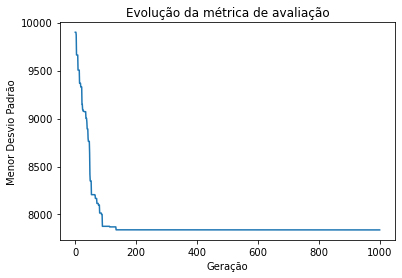

In [173]:

plt.plot(range(max_geracao), metrica)
plt.xlabel('Geração')
plt.ylabel('Menor Desvio Padrão')
plt.title('Evolução da métrica de avaliação')
plt.show()

In [228]:
print('A melhor ordem para os times tem um desvio padrão de :',metrica[-1],', ordenado como abaixo.')
print('A ordem original tinha um desvio padrão de 10402.565550423853. Ou seja, reduzimos o desvio padrão em 25%.')

A melhor ordem para os times tem um desvio padrão de : 7839.042462669399 , ordenado como abaixo.
A ordem original tinha um desvio padrão de 10402.565550423853. Ou seja, reduzimos o desvio padrão em 25%.


In [176]:
melhor_lista_times=[]
for jj in range(gene_pool.shape[1]):
    melhor_lista_times.append(lista_times_21['Time'].tolist()[gene_pool.iloc[0,jj].astype(int)])
melhor_lista_times       

['Atlético Goianiense',
 'Grêmio',
 'Sport',
 'Fortaleza',
 'Palmeiras',
 'Bragantino',
 'São Paulo',
 'Santos',
 'Bahia',
 'Chapecoense',
 'Fluminense',
 'Athlético Paranaense',
 'Juventude',
 'Corinthians',
 'Flamengo',
 'Atlético Mineiro',
 'Cuiabá',
 'América',
 'Ceará',
 'Internacional']

In [243]:
melhor_ordem_times=lista_times.copy()
melhor_ordem_times['Equipe']=melhor_lista_times
percorrido=[]
for ii in range(percursos.shape[0]):
    viagens=0
    for jj in range(percursos.shape[1]-1):
        viagens += distancias.loc[lista_times.loc[percursos.iloc[ii,jj],'Equipe'],
                                  lista_times.loc[percursos.iloc[ii,jj+1],'Equipe']]
    
    percorrido.append(viagens)
melhor_ordem_times['Total Viagem']=percorrido
melhor_ordem_times


,Equipe,Total Viagem
Time,,
Time01,Atlético Goianiense,33927.292345
Time02,Grêmio,32426.720474
Time03,Sport,36496.766288
Time04,Fortaleza,30730.496554
Time05,Palmeiras,47255.369404
Time06,Bragantino,30670.870470
Time07,São Paulo,61438.538206
Time08,Santos,38094.919172
Time09,Bahia,28040.881925


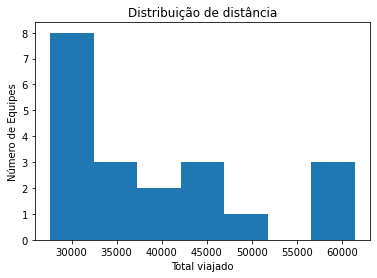

In [245]:
plt.hist(percorrido, bins = 3)
plt.xlabel('Total viajado')
plt.ylabel('Número de Equipes')
plt.title('Distribuição de distância')
plt.show()

Com isso, encerramos a primeira abordagem.

## 7. Otimizando mandos de campo

Vamos tentar otimizar os mandos de campo, mantendo as duas outras tabelas fixas. Ou seja, a questão é definir a sequência de jogos em casa ou fora para cada equipe, mas devemos respeitar a premissa de não ter mais de duas partidas em casa ou fora em sequência.

In [182]:
enfrentamentos_solucao = enfrentamentos.copy()
lista_times_solucao = lista_times.copy()

Para esse exercício, nosso gene é uma tabela semelhante com os mandos de campo, onde cada linha é um dos times e cada coluna é uma rodada. A mutação nesse caso é a escolha aleatória de uma partida na tabela *enfrentamentos*. O mando de campo desse jogo será invertido. Precisamos validar a mutação verificando a premissa 1:
1. Nenhum time pode jogar mais do que duas partidas seguidas em casa ou fora.


Vamos construir uma função nova que verifique essa condição para todas as equipes.

In [187]:
#retorna 0 quando não tem problemas, 1 quando tem
def verificaPremissa(mando_gene):
    ok=0
    for ii in range(mando_gene.shape[0]):
        for jj in range(mando_gene.shape[1]-2):
            teste=mando_gene.iloc[ii,jj]+mando_gene.iloc[ii,jj+1]+mando_gene.iloc[ii,jj+2]
            if teste==0 or teste==3:
                ok=1
        teste=(1-mando_gene.iloc[ii,0])+mando_gene.iloc[ii,-2]+mando_gene.iloc[ii,-1]
        if teste==0 or teste==3:
            ok=1
        teste=(1-mando_gene.iloc[ii,0])+(1-mando_gene.iloc[ii,1])+mando_gene.iloc[ii,-1]
        if teste==0 or teste==3:
            ok=1
    
    return ok
    

Ao final do algoritmo, vamos exibir o gráfico com a evolução do valor da melhor avaliação em cada geração. Esperamos que ao final o sistema atinja um valor otimizado.
Temos quatro parâmetros para definir:

1. o número de genes que vamos avaliar em cada geração: 6;
2. o número de genes que vamos manter de uma geração para outra: 2;
3. o número de gerações: 500;
4. os genes originais.



A criação dos genes originais é mais complicada nessa abordagem. A partir da tabela original, vamos criar 5 novas tabelas, com apenas uma mutação para cada.

**TENTAMOS GERAR 5 NOVAS TABELAS, MAS A FUNÇÃO ABAIXO NÃO RETORNOU NENHUMA MUTAÇÃO QUE RESPEITE A PREMISSA DEPOIS DE 5000 TESTES.** 

In [ ]:
gene_pool=[]
gene_pool.append(mando)
jj=0
for ii in range(5):
    mando_gene=mando.copy()
    ok=1
    #enquanto não passar no teste da premissa
    while ok>0:
        jj+=1
        #sorteio de um time x1 e uma rodada x2
        x1=random.randint(0,19)
        x2=random.randint(0,18)
        equipe1=generico[x1]
        equipe2=enfrentamentos_solucao.iloc[x1,x2]
        mando_gene.loc[equipe1,rodadas[x2]]=1-mando_gene.loc[equipe1,rodadas[x2]]
        mando_gene.loc[equipe2,rodadas[x2]]=1-mando_gene.loc[equipe2,rodadas[x2]]
        
        ok=verificaPremissa(mando_gene)
        if jj%100==0:
            jj=0
            print('não deu')
            break
          
    print('ok')
    gene_pool.append(mando_gene)


Não foi possível terminar essa abordagem, pois não conseguimos gerar mutações validadas.

## 8. Otimizando enfrentamentos

Vamos tentar otimizar a ordem das rodadas, mantendo as duas outras tabelas fixas. Ou seja, a questão é definir a sequência de times que cada um vai enfrentar. De novo, precisamos respeitar a premissa de não ter mais de duas partidas em casa ou fora em sequência.

In [225]:
mando_solucao = mando.copy()
lista_times_solucao = lista_times.copy()

Para esse exercício, nosso gene é um vetor com o reordenamento das rodadas.  

In [226]:
print('Ou seja, o vetor (0,1,2,3,4,5,6,7,8,9,10,11,12,13,141,15,16,17,18,19) é:', rodadas)

Ou seja, o vetor (0,1,2,3,4,5,6,7,8,9,10,11,12,13,141,15,16,17,18,19) é: ['Rodada 1', 'Rodada 2', 'Rodada 3', 'Rodada 4', 'Rodada 5', 'Rodada 6', 'Rodada 7', 'Rodada 8', 'Rodada 9', 'Rodada 10', 'Rodada 11', 'Rodada 12', 'Rodada 13', 'Rodada 14', 'Rodada 15', 'Rodada 16', 'Rodada 17', 'Rodada 18', 'Rodada 19']


Em cada geração, temos 6 genes sendo avaliados. Os dois melhores serão mantidos e serão criados dois novos candidatos a partir de cada um, escolhendo um par de rodadas para ter suas posições trocadas, lembrando que precisamos obedecer a premissa:
1. Nenhum time pode jogar mais do que duas partidas seguidas em casa ou fora.

Ao final, teremos a ordem de rodadas com o menor valor de nossa métrica e um gráfico com a evolução da melhor avaliação de cada geração.



A criação dos genes originais é mais complicada nessa abordagem. A partir da tabela original, vamos criar 5 novas tabelas, com apenas uma mutação para cada.

**TENTAMOS GERAR 5 NOVAS TABELAS, MAS A FUNÇÃO ABAIXO NÃO RETORNOU NENHUMA MUTAÇÃO QUE RESPEITE A PREMISSA DEPOIS DE 5000 TESTES.** 

In [227]:
gene_pool=[]
gene_pool.append(rodadas)
jj=0
for ii in range(5):
    rodadas_gene=rodadas.copy()
    ok=1
    #enquanto não passar no teste da premissa
    while ok>0:
        jj+=1
        x1=random.randint(0,18)
        x2=x1
        while x2==x1:
            x2=random.randint(0,18)
        pos1=rodadas_gene[x1]
        pos2=rodadas_gene[x2]
        rodadas_gene[x1]=pos2
        rodadas_gene[x2]=pos1
                
        ok=verificaPremissa(mando[rodadas_gene])
        if jj%100==0:
            jj=0
            print('não deu')
            break
    print('ok')
    gene_pool.append(rodadas_gene)

não deu
ok
não deu
ok
não deu
ok
não deu
ok
não deu
ok


Não foi possível terminar essa abordagem, pois não conseguimos gerar mutações validadas.

## 9. Conclusão

Realmente, a geração de uma programação para um campeonato com 20 equipes é uma tarefa bem complexa. A partir dos dados do Campeonato Brasileiro de Futebol de 2020, dividimos o problema em três tabelas e tentamos resolvê-lo atacando uma tabela de cada vez. Infelizmente, só conseguimos uma solução para o caso do ordenamento dos times. 

Em compensação, uma vez montado o algoritmo, podemos utilizá-lo para qualquer torneio com 20 equipes. Como encerramento do trabalho, repetimos a análise com os times da Segunda Divisão.

In [291]:
lista_times_21b=pd.read_csv('times_21b.csv')
lista_times_21b['Latitude']=0.
lista_times_21b['Longitude']=0.

for ii in range(lista_times_21b.shape[0]):
    print(ii)
    address = [lista_times_21b.iloc[ii,1],'Brazil']
    location = get_location_by_address(address)
    lista_times_21b.iloc[ii,-2] = float(location["lat"])
    lista_times_21b.iloc[ii,-1] = float(location["lon"])
lista_times_21b.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,Time,Cidade,Latitude,Longitude
0,Avaí,Florianópolis,-27.597300,-48.549610
1,Botafogo,Rio de Janeiro,-22.911014,-43.209373
2,Brasil de Pelotas,Pelotas,-31.769974,-52.341016
3,Brusque,Brusque,-27.096463,-48.913632
4,CRB,Maceió,-9.647684,-35.733926


In [292]:
#mapa centrado em Brasília
map_brasil_b = folium.Map(location=[-10.3333333, -53.2], zoom_start=4)

# add markers to map
for lat, lng, time in zip(lista_times_21b['Latitude'], lista_times_21b['Longitude'], lista_times_21b['Time']):
    label = '{}'.format(time)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brasil_b)  
    
map_brasil_b

In [293]:
distanciasb=pd.DataFrame(columns=['Time']+lista_times_21b['Time'].tolist())
distanciasb['Time']=lista_times_21b['Time'].tolist()
for ii in range(len(lista_times_21b)):
    for jj in range(len(lista_times_21b)):
        loc1=(lista_times_21b.iloc[ii,-2],lista_times_21b.iloc[ii,-1])
        loc2=(lista_times_21b.iloc[jj,-2],lista_times_21b.iloc[jj,-1])
        distanciasb.iloc[ii,jj+1]=hs.haversine(loc1,loc2)
distanciasb=distanciasb.set_index('Time')

distanciasb.head()

,Avaí,Botafogo,Brasil de Pelotas,Brusque,CRB,CSA,Confiança,Coritiba,Cruzeiro,Goiás,Guarani,Londrina,Náutico,Operário-PR,Ponte Preta,Remo,Sampaio Corrêa,Vasco da Gama,Vila Nova,Vitória
Time,,,,,,,,,,,,,,,,,,,,
Avaí,0,748.103,591.014,66.2881,2405.5,2405.5,2208.21,251.504,973.292,1216,542.739,543.819,2604.8,321.761,542.739,2907.4,2821.01,748.103,1216,1932.59
Botafogo,748.103,0,1334.4,739.424,1675.74,1675.74,1484.07,675.611,340.896,937.644,394.475,814.183,1875.55,746.328,394.475,2452.91,2265.3,0,937.644,1211.69
Brasil de Pelotas,591.014,1334.4,0,616.523,2996.45,2996.45,2798.85,765.956,1561.03,1706.53,1114.7,947.727,3195.68,772.812,1114.7,3395.78,3356.49,1334.4,1706.53,2523.13
Brusque,66.2881,739.424,616.523,0,2382.85,2382.85,2184.23,188.747,944.674,1158.69,501.997,477.676,2581.71,255.562,501.997,2852.09,2772.88,739.424,1158.69,1908.39
CRB,2405.5,1675.74,2996.45,2382.85,0,0,203.722,2263.15,1442.96,1658.5,1904.32,2235.2,199.823,2296.2,1904.32,1677.36,1226.71,1675.74,1658.5,476.641


In [294]:
def avaliacao_b(ordem_times,ordem_mandos,ordem_rodadas):
    percursos=[]
    rodadas=ordem_rodadas.columns
    for jj in range(len(generico)):
        percurso_time=[generico[jj]]+2*ordem_rodadas.loc[generico[jj],:].tolist()+[generico[jj]]
        for ii in range(len(rodadas)):
            if mando.loc[generico[jj],rodadas[ii]]==0:
                percurso_time[ii+1]=generico[jj]
            else:
                percurso_time[ii+ordem_times.shape[0]]=generico[jj]

        percursos.append(percurso_time)

    percursos=pd.DataFrame(percursos)
    percorrido=[]
    for ii in range(percursos.shape[0]):
        viagens=0
        for jj in range(percursos.shape[1]-1):
            viagens += distanciasb.loc[ordem_times.loc[percursos.iloc[ii,jj],'Equipe'],
                                      ordem_times.loc[percursos.iloc[ii,jj+1],'Equipe']]

        percorrido.append(viagens)
    
    desvio_padrao = np.std(percorrido)
    return desvio_padrao

In [295]:
enfrentamentos_solucao = enfrentamentos.copy()
mando_solucao = mando.copy()

In [296]:
gene_pool=[]
for ii in range(6):
    gene = random.sample(range(0, 20),k=20)
    gene_pool.append(gene)
        
gene_pool=pd.DataFrame(gene_pool)

In [297]:
geracao=0
max_geracao=500
metrica=[]
while (geracao<max_geracao):
    if (geracao%50==0):
        print('Geração:', geracao)
    notas=[]
    #para cada gene
    for ii in range(gene_pool.shape[0]):
        #criando ordem dos times
        lista_times_gene=[]
        for jj in range(gene_pool.shape[1]):
            lista_times_gene.append(lista_times_21b['Time'].tolist()[gene_pool.iloc[ii,jj].astype(int)])
        
        ordem_times=lista_times.copy()
        ordem_times['Equipe']=lista_times_gene
        #calculando distancias e desvio padrao
        notas.append(avaliacao_b(ordem_times, mando_solucao, enfrentamentos_solucao))
    
    #vamos classificar os resultados
    gene_pool['avaliacao']=notas
    gene_pool = gene_pool.sort_values(by=['avaliacao']).reset_index(drop=True)
    
    #salvando o melhor resultado
    metrica.append(gene_pool.iloc[0,-1])
    
    #gerando novos candidatos
    gene_pool.iloc[2,:]=gene_pool.iloc[0,:]
    gene_pool.iloc[3,:]=gene_pool.iloc[0,:]
    gene_pool.iloc[4,:]=gene_pool.iloc[1,:]
    gene_pool.iloc[5,:]=gene_pool.iloc[1,:]
    
    for ii in range(2,6):
        x1=random.randint(0,19)
        x2=x1
        while x2==x1:
            x2=random.randint(0,19)
        pos1=gene_pool.iloc[ii,x1]
        pos2=gene_pool.iloc[ii,x2]
        gene_pool.iloc[ii,x1]=pos2
        gene_pool.iloc[ii,x2]=pos1
    
    #preparando para próxima geração
    gene_pool.drop(columns=['avaliacao'],inplace=True)
    geracao+=1
    

Geração: 0
Geração: 50
Geração: 100
Geração: 150
Geração: 200
Geração: 250
Geração: 300
Geração: 350
Geração: 400
Geração: 450


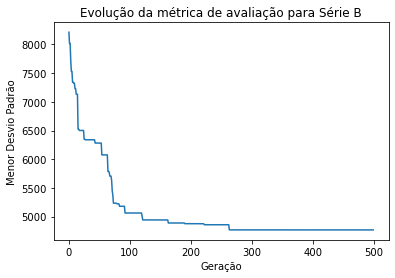

In [298]:
plt.plot(range(max_geracao), metrica)
plt.xlabel('Geração')
plt.ylabel('Menor Desvio Padrão')
plt.title('Evolução da métrica de avaliação para Série B')
plt.show()

In [302]:
print('A melhor ordem para os times tem um desvio padrão de :',metrica[-1],', ordenado como abaixo.')

A melhor ordem para os times tem um desvio padrão de : 4768.920467037452 , ordenado como abaixo.


In [303]:
melhor_lista_times=[]
for jj in range(gene_pool.shape[1]):
    melhor_lista_times.append(lista_times_21b['Time'].tolist()[gene_pool.iloc[0,jj].astype(int)])
melhor_lista_times       

['Ponte Preta',
 'Brasil de Pelotas',
 'Botafogo',
 'Remo',
 'Goiás',
 'Confiança',
 'Avaí',
 'Coritiba',
 'Operário-PR',
 'Londrina',
 'Vasco da Gama',
 'CRB',
 'Brusque',
 'Vitória',
 'Guarani',
 'Sampaio Corrêa',
 'Vila Nova',
 'Cruzeiro',
 'Náutico',
 'CSA']

In [312]:
melhor_ordem_times=lista_times.copy()
melhor_ordem_times['Equipe']=melhor_lista_times
percorrido=[]
for ii in range(percursos.shape[0]):
    viagens=0
    for jj in range(percursos.shape[1]-1):
        viagens += distanciasb.loc[melhor_ordem_times.loc[percursos.iloc[ii,jj],'Equipe'],
                                  melhor_ordem_times.loc[percursos.iloc[ii,jj+1],'Equipe']]
    
    percorrido.append(viagens)
melhor_ordem_times['Total Viagem']=percorrido
melhor_ordem_times


,Equipe,Total Viagem
Time,,
Time01,Ponte Preta,39406.485408
Time02,Brasil de Pelotas,51536.853359
Time03,Botafogo,39263.240948
Time04,Remo,53853.594152
Time05,Goiás,40275.625558
Time06,Confiança,47663.107693
Time07,Avaí,41278.159467
Time08,Coritiba,43867.769510
Time09,Operário-PR,42652.427038


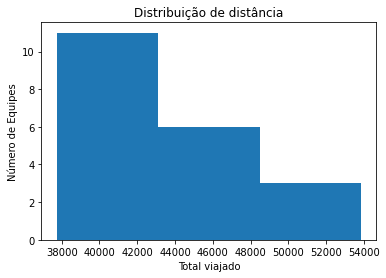

In [313]:
plt.hist(percorrido, bins = 3)
plt.xlabel('Total viajado')
plt.ylabel('Número de Equipes')
plt.title('Distribuição de distância')
plt.show()